In [1]:
import cv2
import numpy as np


Installer openCV sur anaconda avec Python 3.6 :<br>
https://www.scivision.co/install-opencv-python-windows/<br>
http://www.lfd.uci.edu/~gohlke/pythonlibs/#opencv

Constantes :<br>
https://github.com/opencv/opencv/blob/e3ae36dcb3c1d523802f8642e5c3984db43637c4/modules/python/src2/defs

# Capture des images par Webcam

In [97]:
# capture et masque live
cap = cv2.VideoCapture(1)

# il faut installer le pilote pour avoir une meilleure résolution
# http://suporte.multilaser.com.br/downloads/detalhe/WC040/
cap.set(3,1020)
cap.set(4,840)

print(cap.get(3))
print(cap.get(4))

i = 0
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # define range of blue color in HSV
    #l = np.array([140,20,70])
    #u = np.array([60,45,100])

    # Threshold the HSV image to get only blue colors
    #mask = cv2.inRange(hsv, l, u)
    #l = 170
    #u = 255
    #mask = cv2.inRange(gray, l, u)

    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(frame,frame, mask= mask)
    
    masque_ecran = cv2.inRange(gray, 80, 255)

    cv2.imshow('frame',frame)
    #cv2.imshow('mask',mask)
    cv2.imshow('res',res)
    cv2.imshow('ecran',masque_ecran)
    
    if i == 100:
        cv2.imwrite("masque_ecran.jpg", masque_ecran)
        cv2.imwrite("ecran.jpg", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    i += 1

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

1024.0
768.0


# Détection des bords de l'écran

In [98]:
img = cv2.imread('masque_ecran.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

# détection des lignes verticales en jouant sur les paramètres : on n'en veut que 2
lines1 = cv2.HoughLines(image=edges,rho=1,theta=np.pi/180,threshold=80)
# cone d'angle accepté autour de la verticale
thetamax = 0.07
thetamin = 3
i = 1
for x in range(0, len(lines1)):
    for rho, theta in lines1[x]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        if (theta >= thetamin or theta <= thetamax):
            print(rho, theta)
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
            if i == 1:
                dv1rho = rho
                dv1theta = theta
                vx11 = x1
                vy11 = y1
                vx12 = x2
                vy12 = y2
                
            else:
                dv2rho = rho
                dv2theta = theta
                vx21 = x1
                vy21 = y1
                vx22 = x2
                vy22 = y2
            i += 1
            
# détection des lignes horizontales en jouant sur les paramètres : on n'en veut que 2
lines1 = cv2.HoughLines(image=edges,rho=1,theta=np.pi/500,threshold=390)

i = 1
for x in range(0, len(lines1)):
    for rho, theta in lines1[x]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        print(rho, theta)
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
        
        if i == 1:
            dh1rho = rho
            dh1theta = theta
            hx11 = x1
            hy11 = y1
            hx12 = x2
            hy12 = y2
        else:
            dh2rho = rho
            dh2theta = theta
            hx21 = x1
            hy21 = y1
            hx22 = x2
            hy22 = y2
        i += 1

#minLineLength = 2
#maxLineGap = 500
#lines2 = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/2,threshold=100,minLineLength=minLineLength,maxLineGap=maxLineGap)  
#for x in range(0, len(lines2)):
#    for x1,y1,x2,y2 in lines2[x]:
#        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)


cv2.imwrite('out_masque.jpg',img)
#cv2.imwrite('houghlines2.jpg',edges)


21.0 3.00197
-939.0 3.08923
337.0 1.47655
546.0 1.46398


True

# Transformation affine de l'écran

Maintenant, on fait une transformation affine pour que l'écran ait la forme d'un rectangle

$x_1 = \rho_1 cos(\theta_1) - \rho_{t1} sin(\theta_1)$<br>
$x_2 = \rho_2 cos(\theta_2) - \rho_{t2} sin(\theta_2)$<br>
$y_1 = \rho_1 sin(\theta_1) + \rho_{t1} cos(\theta_1)$<br>
$y_2 = \rho_2 sin(\theta_2) + \rho_{t2} cos(\theta_2)$<br>

$x_1 = x_2 => \rho_1 cos(\theta_1) - \rho_{t1} sin(\theta_1) = \rho_2 cos(\theta_2) - \rho_{t2} sin(\theta_2)$<br>
$y_1 = y_2 => \rho_1 sin(\theta_1) + \rho_{t1} cos(\theta_1) = \rho_2 sin(\theta_2) + \rho_{t2} cos(\theta_2)$

$ \rho_{t1} = \frac{\rho_1 cos(\theta_1) - \rho_2 cos(\theta_2) + \rho_{t2} sin(\theta_2)}{sin(\theta_1)} $<br>
$\rho_{t2} = \frac{\rho_1 sin(\theta_1) + \rho_{t1} cos(\theta_1) - \rho_2 sin(\theta_2)}{cos(\theta_2)}$

$ \rho_{t1} = \frac{\rho_1 cos(\theta_1) - \rho_2 cos(\theta_2) + \frac{\rho_1 sin(\theta_1) + \rho_{t1} cos(\theta_1) - \rho_2 sin(\theta_2)}{cos(\theta_2)} sin(\theta_2)}{sin(\theta_1)} $

$ \rho_{t1} sin(\theta_1) cos(\theta_2) = \rho_1 cos(\theta_1) cos(\theta_2) - \rho_2 cos(\theta_2) ^2 + [\rho_1 sin(\theta_1) + \rho_{t1} cos(\theta1) - \rho_2 sin(\theta_2)) ] sin(\theta_2)$

$ \rho_{t1} sin(\theta_1) cos(\theta_2) - \rho_{t1} cos(\theta_1) sin(\theta_2) = \rho_1 cos(\theta_1) cos(\theta_2) - \rho_2 cos(\theta_2) ^2 + [\rho_1 sin(\theta_1) - \rho_2 sin(\theta_2)) ] sin(\theta_2)$

$ \rho_{t1} = \frac{\rho_1 cos(\theta_1) cos(\theta_2) - \rho_2 cos(\theta_2) ^2 + [\rho_1 sin(\theta_1) - \rho_2 sin(\theta_2)) ] sin(\theta_2)}{sin(\theta_1) cos(\theta_2) - cos(\theta_1) sin(\theta_2)} $

In [100]:
# on calcule les 4 points des 4 côtés
# on prend la première droite verticale, et on cherche les intersections avec les 2 droites horizontales
rho1 = dv1rho
theta1 = dv1theta
rho2 = dh1rho
theta2 = dh1theta
rho = ( rho1 * np.cos(theta1) * np.cos(theta2) - rho2 * np.cos(theta2)**2 + (rho1 * np.sin(theta1) - rho2 * np.sin(theta2)) * np.sin(theta2) / (np.sin(theta1) * np.cos(theta2) - np.cos(theta1) * np.sin(theta2)))
x = int(np.cos(theta1) * rho1 - rho * np.sin(theta1))
y = int(np.sin(theta1) * rho1 + rho * np.cos(theta1))
r = cv2.circle(img,(x,y), 5, (0,255,0), -1)
P1 = (x, y)

rho1 = dv1rho
theta1 = dv1theta
rho2 = dh2rho
theta2 = dh2theta
rho = ( rho1 * np.cos(theta1) * np.cos(theta2) - rho2 * np.cos(theta2)**2 + (rho1 * np.sin(theta1) - rho2 * np.sin(theta2)) * np.sin(theta2) / (np.sin(theta1) * np.cos(theta2) - np.cos(theta1) * np.sin(theta2)))
x = int(np.cos(theta1) * rho1 - rho * np.sin(theta1))
y = int(np.sin(theta1) * rho1 + rho * np.cos(theta1))
r = cv2.circle(img,(x,y), 5, (0,255,0), -1)
P2 = (x, y)

# idem avec la 2eme verticale
# attention, il faut inverser horizontale et verticale à cause de l'angle
# !!!!!!!!! corriger ça
rho1 = dv2rho
theta1 = dv2theta
rho2 = dh1rho
theta2 = dh1theta

rho = ( rho1 * np.cos(theta1) * np.cos(theta2) - rho2 * np.cos(theta2)**2 + (rho1 * np.sin(theta1) - rho2 * np.sin(theta2)) * np.sin(theta2) / (np.sin(theta1) * np.cos(theta2) - np.cos(theta1) * np.sin(theta2)))
x = int(np.cos(theta1) * rho1 - rho * np.sin(theta1))
y = int(np.sin(theta1) * rho1 + rho * np.cos(theta1))
r = cv2.circle(img,(x,y), 5, (0,255,0), -1)
P3 = (x, y)

rho1 = dv2rho
theta1 = dv2theta
rho2 = dh2rho
theta2 = dh2theta

rho = ( rho1 * np.cos(theta1) * np.cos(theta2) - rho2 * np.cos(theta2)**2 + (rho1 * np.sin(theta1) - rho2 * np.sin(theta2)) * np.sin(theta2) / (np.sin(theta1) * np.cos(theta2) - np.cos(theta1) * np.sin(theta2)))
x = int(np.cos(theta1) * rho1 - rho * np.sin(theta1))
y = int(np.sin(theta1) * rho1 + rho * np.cos(theta1))
r = cv2.circle(img,(x,y), 5, (0,255,0), -1)
P4 = (x, y)

cv2.imwrite('out_masque_lines.jpg',img)

True

In [104]:
(P1, P2, P3, P4)

((26, 336), (55, 543), (953, 248), (963, 445))

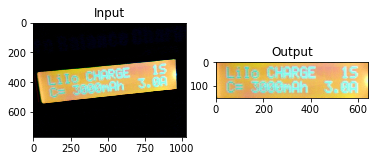

True

In [105]:
img = cv2.imread('ecran.jpg')
rows,cols,ch = img.shape
# taille mesurée de l'écran, en dixièeme de mm
larg = 644
haut = 151

pts1 = np.float32([P1, P2, P3, P4])
pts2 = np.float32([[0,0],[0,haut],[larg,0],[larg,haut]])

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(img,M,(larg,haut)) 

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

cv2.imwrite('out_ecran.jpg',dst)

# Préparation de l'image pour l'OCR

In [9]:
## avec la détection des coins d'OpenCV (moins précis)
#filename = 'ecran.jpg'
#
#img = cv2.imread(filename)
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#
## find Harris corners
#gray = np.float32(gray)
#dst = cv2.cornerHarris(gray,30,3,0.04)
#dst = cv2.dilate(dst,None)
#ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
#dst = np.uint8(dst)
#
## find centroids
#ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
#
## define the criteria to stop and refine the corners
#criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
#corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
#
## Now draw them
#res = np.hstack((centroids,corners))
#res = np.int0(res)
#img[res[:,1],res[:,0]]=[0,0,255]
#img[res[:,3],res[:,2]] = [0,255,0]
#
#cv2.imwrite('subpixel5.png',img)


True

In [135]:
img = cv2.imread('out_ecran.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,53,55,apertureSize = 3, L2gradient =True)
cv2.imwrite('out_ecran_gray.jpg',gray)
cv2.imwrite('out_ecran_edges.jpg',edges)

True

In [153]:
cv2.ADAPTIVE_THRESH_MEAN_C = 0

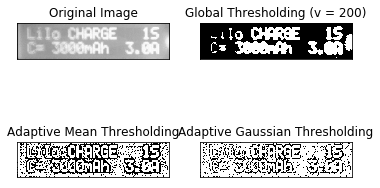

In [160]:

img = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

ret,th1 = cv2.threshold(img,185,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 200)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

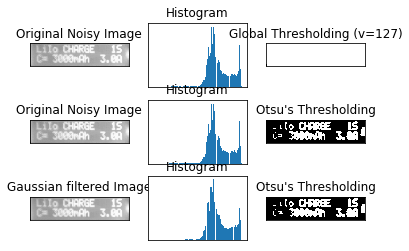

In [116]:
# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

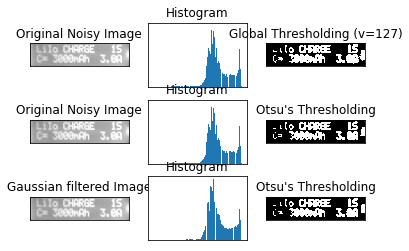

In [162]:
img = cv2.imread('out_ecran_gray.jpg',0)

# global thresholding
ret1,th1 = cv2.threshold(img,185,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

# Utilisation de Tesseract